# 1.Imports

In [1]:
from helpers import *
from implementations import *
from medical_dataset_helpers.pipeline import Pipeline
from medical_dataset_helpers.preprocessing import MinMaxScaler, StandardScaler
from medical_dataset_helpers.ensemble_models import RandomForestClassifier
from medical_dataset_helpers.model_selection import KFold, GridSearchCV, train_test_split
from medical_dataset_helpers.metrics_utils import classification_report
from medical_dataset_helpers.linear_models import LogisticRegression
from medical_dataset_helpers.neural_network import MLPClassifier

import numpy as np
from matplotlib import pyplot as plt

# 2. Data Processing

## 2.1 Loading 

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./data/dataset")

## 2.2 Basic Data Observations

In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(train_ids.shape)
print(test_ids.shape)

(328135, 321)
(109379, 321)
(328135,)
(328135,)
(109379,)


### 2.2.1 NaN analysis

In [4]:
total_nans = np.isnan(x_train).sum()
print(f"Total NaN values in x_train: {total_nans}")
print(f"Percentage: {100 * total_nans / x_train.size:.2f}%")

total_nans_test = np.isnan(x_test).sum()
print(f"\nTotal NaN values in x_test: {total_nans_test}")
print(f"Percentage: {100 * total_nans_test / x_test.size:.2f}%")

Total NaN values in x_train: 47175779
Percentage: 44.79%

Total NaN values in x_test: 15724379
Percentage: 44.79%


In [5]:
cols_with_nans = np.where(np.isnan(x_train).any(axis=0))[0]
print(f"Number of columns with NaN: {len(cols_with_nans)}")

nans_per_col = np.isnan(x_train).sum(axis=0)
cols_with_nans_counts = nans_per_col[cols_with_nans]


Number of columns with NaN: 239


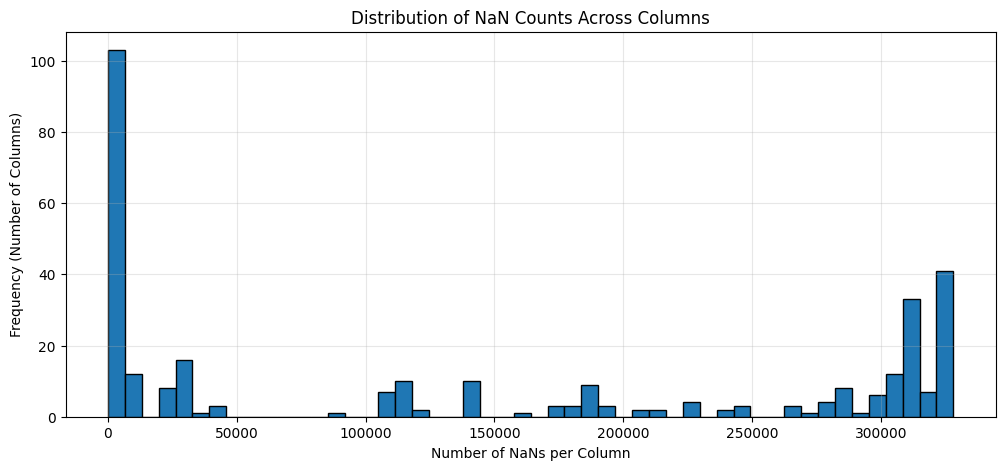

In [6]:
plt.figure(figsize=(12, 5))

nans_per_col_hist = np.isnan(x_train).sum(axis=0)
plt.hist(nans_per_col_hist, bins=50, edgecolor='black')
plt.xlabel('Number of NaNs per Column')
plt.ylabel('Frequency (Number of Columns)')
plt.title('Distribution of NaN Counts Across Columns')
plt.grid(True, alpha=0.3)

plt.show()

In [7]:
print("=== NaN Summary Statistics ===\n")

print("Per Column:")
print(f"  Mean NaNs per column: {np.mean(nans_per_col):.2f}")
print(f"  Max NaNs in a column: {np.max(nans_per_col)}")
print(f"  Columns with ALL NaNs: {np.sum(nans_per_col == x_train.shape[0])}")
print(f"  Columns with NO NaNs: {np.sum(nans_per_col == 0)}")

=== NaN Summary Statistics ===

Per Column:
  Mean NaNs per column: 146965.04
  Max NaNs in a column: 328103
  Columns with ALL NaNs: 0
  Columns with NO NaNs: 82


## 2.3 Cleaning the Data

In [8]:
cols_with_nans = np.where(np.isnan(x_train).any(axis=0))[0]
print(f"Number of columns with NaN: {len(cols_with_nans)}")
temporary_stacked_x = np.vstack((x_train, x_test))
valid_cols = np.where(~np.isnan(temporary_stacked_x).any(axis=0))[0]
print(f"Number of columns without NaN: {len(valid_cols)}")
x_train_clean = x_train[:, valid_cols]
x_test_clean = x_test[:, valid_cols]

print(f"\nOriginal shapes:")
print(f"  x_train: {x_train.shape}")
print(f"  x_test: {x_test.shape}")

print(f"\nCleaned shapes:")
print(f"  x_train_clean: {x_train_clean.shape}")
print(f"  x_test_clean: {x_test_clean.shape}")

print(f"\nRemoved {x_train.shape[1] - x_train_clean.shape[1]} columns")
print(f"Remaining columns: {x_train_clean.shape[1]} out of {x_train.shape[1]}")

Number of columns with NaN: 239
Number of columns without NaN: 82

Original shapes:
  x_train: (328135, 321)
  x_test: (109379, 321)

Cleaned shapes:
  x_train_clean: (328135, 82)
  x_test_clean: (109379, 82)

Removed 239 columns
Remaining columns: 82 out of 321


## 2.4 Fix data imbalance

In [9]:
y_train_binary = (y_train + 1) // 2
n_positive = np.sum(y_train_binary == 1)
n_negative = np.sum(y_train_binary == 0)

print(f"Original dataset:")
print(f"  Positive samples: {n_positive}")
print(f" Negative samples: {n_negative}")
print(f"  Ratio: {n_negative/n_positive:.2f}:1")

positive_indices = np.where(y_train_binary == 1)[0]
negative_indices = np.where(y_train_binary == 0)[0]

n_oversample = n_negative // n_positive 
oversampled_positive_indices = np.repeat(positive_indices, n_oversample)
balanced_indices = np.concatenate([negative_indices, oversampled_positive_indices])
np.random.seed(42)
np.random.shuffle(balanced_indices)
# Use the CLEANED data (without NaN columns) for balancing
x_train_balanced = x_train_clean[balanced_indices]
y_train_balanced = y_train[balanced_indices]
y_train_binary_balanced = (y_train_balanced + 1) // 2

print(f"\nBalanced dataset:")
print(f"  Positive samples: {np.sum(y_train_binary_balanced == 1)}")
print(f"  Negative samples: {np.sum(y_train_binary_balanced == 0)}")
print(f"  Total samples: {len(x_train_balanced)}")
print(f"  Ratio: {np.sum(y_train_binary_balanced == 0)/np.sum(y_train_binary_balanced == 1):.2f}:1")

Original dataset:
  Positive samples: 28975
 Negative samples: 299160
  Ratio: 10.32:1

Balanced dataset:
  Positive samples: 289750
  Negative samples: 299160
  Total samples: 588910
  Ratio: 1.03:1


# 3. Training

In [10]:
x_train_balanced_to_use, x_validation, y_train_balanced_to_use, y_validation = train_test_split(x_train_balanced, y_train_binary_balanced, 0.2)

## 3.1 Logistic Regression

In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, learning_rate=0.1, penalty='l2', random_state=42, C=1000)
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lr', lr)
])

param_grid = {'lr__C': [10, 100, 1000]}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(x_train_balanced_to_use, y_train_balanced_to_use)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)
print("\n" + "="*50 + "\n")

y_validation_pred = grid_search.predict(x_validation)

print("Classification Report on Validation Set:")
print("="*50)
classification_report(y_validation, y_validation_pred)

Fitting 1/3: {'lr__C': 10}
Fitting 2/3: {'lr__C': 100}
Fitting 3/3: {'lr__C': 1000}
Refitting best estimator with params: {'lr__C': 1000}
Best parameters: {'lr__C': 1000}
Best CV score: 0.7226125385060405


Classification Report on Validation Set:
Accuracy: 0.725424937597

                 precision     recall   f1-score    support

              0       0.75       0.68       0.72      59861
              1       0.70       0.77       0.73      57921

       accuracy                             0.73     117782

      macro avg       0.73       0.73       0.73     117782
   weighted avg       0.73       0.73       0.72     117782


## 3.2 KNN

In [ ]:
import numpy as np
from medical_dataset_helpers.neighbors import KNeighborsClassifier
from medical_dataset_helpers.model_selection import KFold, GridSearchCV
from medical_dataset_helpers.metrics_utils import classification_report

n_samples = x_train_balanced_to_use.shape[0]
subset_size = n_samples // 3
rng = np.random.RandomState(42)
subset_idx = rng.permutation(n_samples)[:subset_size]

X_sub = x_train_balanced_to_use[subset_idx]
y_sub = y_train_balanced_to_use[subset_idx]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 11],
    'weights': ['uniform', 'distance'],
}

grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=1,
)

grid_search_knn.fit(X_sub, y_sub)

print("Best parameters:", grid_search_knn.best_params_)
print("Best CV score:", grid_search_knn.best_score_)
print("\n" + "="*50 + "\n")

y_val_pred_knn = grid_search_knn.predict(x_validation)

print("KNN Classification Report on Validation Set:")
print("="*50)
classification_report(y_validation, y_val_pred_knn)

## 3.3 Random Forest

In [12]:

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    criterion='gini',
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1, 
    verbose=0
)

rf.fit(x_train_balanced_to_use, y_train_balanced_to_use)

y_val_pred_rf = rf.predict(x_validation)

print("Random Forest (max_depth=300) Classification Report on Validation Set:")
print("="*50)
classification_report(y_validation, y_val_pred_rf)

Random Forest (max_depth=300) Classification Report on Validation Set:
Accuracy: 0.987807984242

                 precision     recall   f1-score    support

              0       1.00       0.98       0.99      59861
              1       0.98       1.00       0.99      57921

       accuracy                             0.99     117782

      macro avg       0.99       0.99       0.99     117782
   weighted avg       0.99       0.99       0.99     117782


## 3.4 MLP Classifier - With MinMaxNormalization

In [ ]:

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    alpha=1e-4,
    max_iter=100,
    batch_size='auto',
    shuffle=True,
    random_state=42,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=False,
)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', mlp)
])

pipeline.fit(x_train_balanced_to_use, y_train_balanced_to_use)
y_val_pred_mlp = pipeline.predict(x_validation)

print("MLP Classification Report on Validation Set:")
print("="*50)
classification_report(y_validation, y_val_pred_mlp)

MLP Classification Report on Validation Set:
Accuracy: 0.795673362653

                 precision     recall   f1-score    support

              0       0.82       0.76       0.79      59861
              1       0.77       0.83       0.80      57921

       accuracy                             0.80     117782

      macro avg       0.80       0.80       0.80     117782
   weighted avg       0.80       0.80       0.80     117782
